In [26]:
import astropy.units as u
import astropy.wcs
import h5py
import matplotlib.pyplot as plt
import ndcube
import numpy as np

from synthesizAR.analysis import make_slope_map
from synthesizAR.instruments.util import extend_celestial_wcs

In [2]:
def emcube_hdf5_to_ndcube(filename):
    # Read in data from file
    with h5py.File(filename) as hf:
        ds = hf['emission_measure']
        em_array = u.Quantity(ds, ds.attrs['unit'])
        ds = hf['temperature_bin_edges']
        tbin_edges = u.Quantity(ds, ds.attrs['unit'])
        meta = dict(hf['meta'].attrs)
    
    log_tbin_edges = np.log10(tbin_edges.to_value('K'))
    tbin_centers = 10**((log_tbin_edges[:-1] + log_tbin_edges[1:])/2)*u.K
    
    em_array = np.swapaxes(np.swapaxes(em_array, 0, 2),1,2)
    
    celestial_wcs = astropy.wcs.WCS(header=meta)
    full_wcs = extend_celestial_wcs(celestial_wcs, tbin_centers, 'temperature', 'phys.temperature')
    dem_cube = ndcube.NDCube(em_array, wcs=full_wcs, meta=meta)
    return dem_cube

In [44]:
hf_dem = emcube_hdf5_to_ndcube('../Documents/papers/synthetic-observables-paper-models/paper/data/high_frequency/em_cube.h5')

In [45]:
slope_map_hf = make_slope_map(hf_dem,
                              temperature_bounds=(8e5*u.K, None),
                              mask_negative=True,
                              rsquared_tolerance=0.75,)

/Users/wtbarnes/Documents/codes/synthesizAR/synthesizAR/analysis/dem.py:44: RuntimeWarning: invalid value encountered in log10
  log_em_valid = np.log10(dem.data[:, *is_valid]).T


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


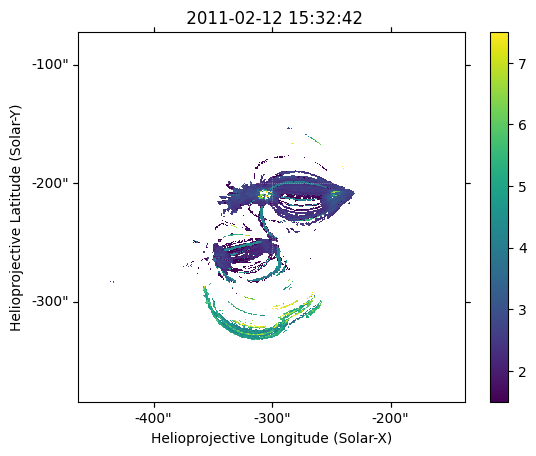

In [46]:
slope_map_hf.peek(vmin=1.5,vmax=7.5,cmap='viridis')

(1.5, 7.5)

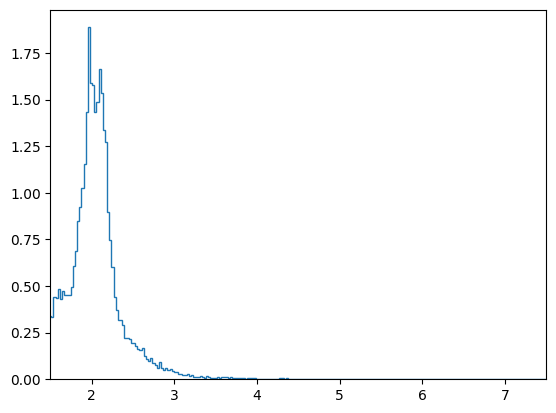

In [43]:
plt.hist(slope_map_hf.data[~slope_map_hf.mask],
         histtype='step',
         density=True,
         bins='fd');
plt.xlim(1.5,7.5)

In [12]:
def make_slope_map_old(emcube, temperature_lower_bound=None, em_threshold=None):
    """
    Fit emission measure distribution in every pixel
    
    The fit is computed between `temperature_lower_bound`
    and the temeperature at which the EM is maximum.
    
    Parameters
    ----------
    emcube: `EMCube`
        Emission measure map as a function space and temperature
    em_threshold: `~astropy.units.Quantity`, optional
        If the total EM in a pixel is below this, no slope is calculated
        
    Returns
    -------
    slope_map: `~sunpy.map.GenericMap`
    rsquared_map: `~sunpy.map.GenericMap`
    """
    # Do some things here to try and 
    
    if em_threshold is None:
        em_threshold = u.Quantity(1e25, u.cm**(-5))
    i_valid = np.where(
        u.Quantity(emcube.total_emission.data, emcube[0].meta['bunit']) > em_threshold)
    em_valid = np.log10(emcube.as_array()[i_valid])
    em_valid[np.logical_or(np.isinf(em_valid), np.isnan(em_valid))] = 0.0
    i_peak = em_valid.argmax(axis=1)
    log_temperature_bin_centers = np.log10(emcube.temperature_bin_centers.value)
    if temperature_lower_bound is None:
        i_lower = 0
    else:
        i_lower = np.fabs(emcube.temperature_bin_centers - temperature_lower_bound).argmin()
    slopes, rsquared = [], []
    for emv, ip in zip(em_valid, i_peak):
        t_fit = log_temperature_bin_centers[i_lower:ip]
        if t_fit.size < 3:
            warnings.warn('Fit should be over 3 or more bins in temperature.')
        if t_fit.size == 0:
            slopes.append(np.nan)
            rsquared.append(0.)
            continue
        em_fit = emv[i_lower:ip]
        w = np.where(em_fit > 0, 1, 0)
        coeff, rss, _, _, _ = np.polyfit(t_fit, em_fit, 1, full=True, w=w)
        rss = 1 if rss.size == 0 else rss[0]
        _, rss_flat, _, _, _ = np.polyfit(t_fit, em_fit, 0, full=True, w=w)
        rss_flat = 1 if rss_flat.size == 0 else rss_flat[0]
        slopes.append(coeff[0])
        rsquared.append(1-rss/rss_flat)
    slopes_data = np.zeros(emcube.total_emission.data.shape)
    slopes_data[i_valid] = slopes
    rsquared_data = np.zeros(emcube.total_emission.data.shape)
    rsquared_data[i_valid] = rsquared
    
    return Map(slopes_data, emcube[0].meta,), Map(rsquared_data, emcube[0].meta)

[0.88839884 0.39707736 0.54517716 0.78848325 0.33212666 0.73012271
 0.9251789  0.03982838 0.05685744 0.21587444 0.66428902 0.11372907
 0.99812294 0.97647544 0.61638702 0.09729814 0.8686113  0.0369149
 0.96100789 0.10454464]
[0.57941707 0.43276882 0.07671858 0.79264601 0.06285733 0.42917734
 0.12781313 0.53748896 0.7822822  0.06056732 0.58800304 0.00622761
 0.58695837 0.87610771 0.93566853 0.86481452 0.09471704 0.44102473
 0.15846034 0.68072859]
[0.54291697 0.06492682 0.07606387 0.95884995 0.01736005 0.8742248
 0.01088568 0.5364319  0.22602476 0.28782018 0.69256443 0.89038307
 0.98770131 0.45379605 0.74518433 0.85469485 0.88333015 0.97514129
 0.3549181  0.82345981]
